### import packages & define functions

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# function to group consecutive frame indices into motion events

def group_consec_frames(frame_list, max_gap=1):
    """
    frame_list: sorted list of frame indices with motion
    max_gap: max allowed gap between grames within the same event
    """

    if not frame_list:
        return []
    
    events = []
    current_event = [frame_list[0]]

    for f in frame_list[1:]:
        if f - current_event[-1] <= max_gap:
            current_event.append(f)
        else:
            events.append(current_event)
            current_event = [f]

    events.append(current_event)
    return events

In [ ]:
# function to check if an object crosses the line_y (to select motion events that involve trash thrown into bins)

def contains_line_crossing(clip_path, line_y, start, end, min_area=100):
    """
    returns True if a moving object crosses over the line_y between frames `start` and `end`

    clip_path: path to video
    line_y: y-coordinate of the horizonal line
    start: starting frame index
    end: ending frame index
    min_area: min contour area to consider as motion
    """

    cap = cv2.VideoCapture(clip_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)   # move the video to start at frame `start`

    ret, prev_frame = cap.read()   # read the first frame of the event
    if not ret:
        cap.release()
        return False
    
    prev_grey = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)   # convert to greyscale for easier processing
    prev_grey = cv2.GaussianBlur(prev_grey, (5,5), 0)   # apply gaussian blur to reduce noise
    prev_centroids = []   # to keep track of object centroids from the previous frame

    for _ in range(start+1, end+1):   # loop through all frames in the event
        ret, frame = cap.read()
        if not ret:
            break

        grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        grey = cv2.GaussianBlur(grey, (5,5), 0)

        frame_delta = cv2.absdiff(prev_grey, grey)   # pixel-wise difference between current & previous frame, white pixels (255) indicate motion
        thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]   # turn small differences into black (0), large differences into white (255)
        thresh = cv2.dilate(thresh, None, iterations=2)   # enlarge white regions so small gaps in moving objects don't split them into multiple regions

        contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   # find all separate white regions in `thresh`
        centroids = []   # to store the center coordinates of each moving object in the current frame
        for contour in contours:
            if cv2.contourArea(contour) < min_area:   # ignore small contours (likely noise)
                continue
            M = cv2.moments(contour)   # compute spatial properties of the contour
            if M["m00"] == 0:
                continue
            cx = int(M["m10"]/M["m00"])   # calculate centroid (cx, cy) of the contour
            cy = int(M["m01"]/M["m00"])
            centroids.append((cx, cy))

        for (cx, cy) in centroids:
            for (pcx, pcy) in prev_centroids:
                if pcy > line_y >= cy:   # compare current centroids with centroids from the previous frame (check whether it crosses the bin opening line)
                    cap.release()
                    return True

        prev_grey = grey   # update for next frame comparison
        prev_centroids = centroids

    cap.release()
    return False

In [3]:
# function to expand each motion event with padding (capture a little before and after motion event)

def expand_event(start, end, pad=10):
    return max(0, start-pad), end+pad

In [4]:
# function to clip motion events into separate video files

def save_clip(start, end, input_video, output_path):
    cap = cv2.VideoCapture(input_video)
    fps = cap.get(cv2.CAP_PROP_FPS)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path,
                          cv2.VideoWriter_fourcc(*"mp4v"),
                          fps,
                          (width, height))
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start)   # go to the start frame

    for f in range(start, end+1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    cap.release()
    out.release()

In [5]:
# function to extract frames from all video clips in a folder and save it into a new folder

def extract_frames(clips_dir, frames_base_dir="frames", frame_step=1):
    """
    clips_dir: folder containing all video clips
    frames_base_dir: parent folder to hold all clip frame folders
    frame_step: extract every nth frame
    """

    os.makedirs(frames_base_dir, exist_ok=True)

    for filename in os.listdir(clips_dir):
        if not filename.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            continue
        if filename.startswith("._"):
            continue

        clip_path = os.path.join(clips_dir, filename)
        clip_name = os.path.splitext(filename)[0]
        output_dir = os.path.join(frames_base_dir, clip_name)
        os.makedirs(output_dir, exist_ok=True)

        cap = cv2.VideoCapture(clip_path)
        
        frame_index = 0
        saved_index = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_index % frame_step == 0:
                frame_filename = os.path.join(output_dir, f"frame_{saved_index:05d}.jpg")
                cv2.imwrite(frame_filename, frame)
                saved_index += 1

            frame_index += 1

        cap.release()
        print(f"saved {saved_index} frames from {filename} to {output_dir}")

### video labels

In [6]:
base_name = "GX030079"
input_video = f"{base_name}.MP4"

base_name_cropped = f"{base_name}_cropped"
cropped_video = f"{base_name_cropped}.MP4"

### load and display first frame to get coordinates of crop region

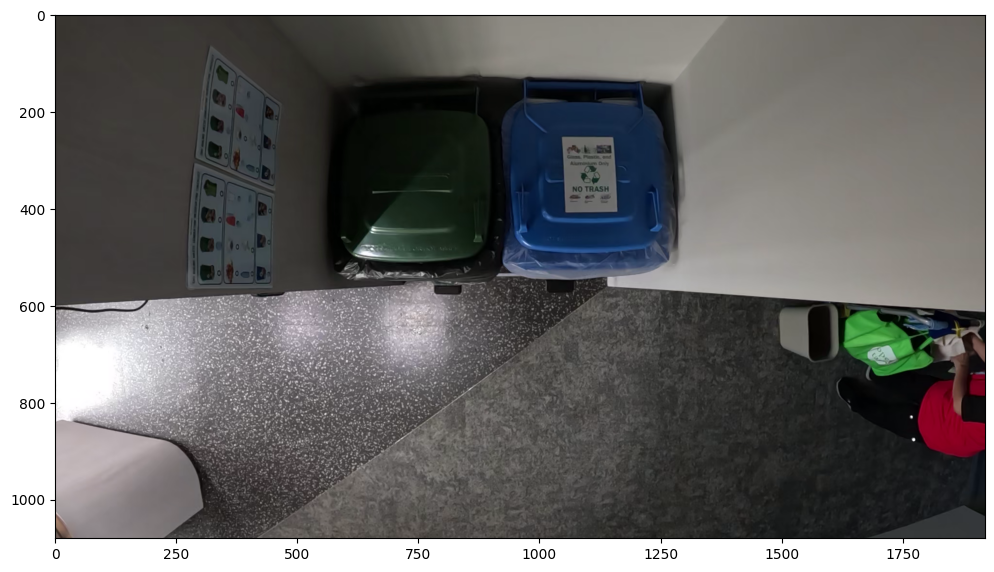

In [8]:
cap = cv2.VideoCapture(input_video)

ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)   # convert bgr to rgb for display

plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)

### crop video to include only bins

In [9]:
# define crop region
x1, y1 = 500, 50   # top-left corner of the crop
x2, y2 = 1350, 600 # bottom-right corner of the crop

cap = cv2.VideoCapture(input_video)   # open input video file
fourcc = cv2.VideoWriter_fourcc(*"mp4v")   # video codec used for saving the output - mp4v
fps = cap.get(cv2.CAP_PROP_FPS)   # input video fps

# create video file where cropped frames will be written
out = cv2.VideoWriter(cropped_video,     # output file path
                      fourcc,           # codec
                      fps,              # fps (to match input video)
                      (x2-x1, y2-y1))   # width & height of the cropped area

while True:   # read frames in a loop
    ret, frame = cap.read()   # ret = True if a frame was successfully read, False if video ended
    if not ret:   # stop when no more frames
        break
    crop = frame[y1:y2, x1:x2]
    out.write(crop)   # add cropped grame into output video file

cap.release()
out.release()

### apply motion detection to extract relevant parts of the video

In [13]:
# get frames with motion

cap = cv2.VideoCapture(cropped_video)   # open cropped video file

# mog2 learns a background model (what the scene looks like when nothing moves)
fgbg = cv2.createBackgroundSubtractorMOG2(history=500,       # how many frames are used to learn / update the background
                                          varThreshold=25)   # threshold for detecting foreground objects

frame_indices = []   # store frame number where motion is detected

frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    fgmask = fgbg.apply(frame)   # apply background subtractor to get foreground mask (white pixels - 255)
    thresh = cv2.threshold(fgmask, 240, 255,  # include anything > 240 into foreground (to account for varying greyscale intensities)
                           cv2.THRESH_BINARY)[1]

    motion_pixels = cv2.countNonZero(thresh)   # count how many pixels contain motion

    if motion_pixels > 10000:   # decide whether frame contains movement, need to adjust and see what is best
        frame_indices.append(frame_id)

    frame_id += 1   # move to the next frame

cap.release()

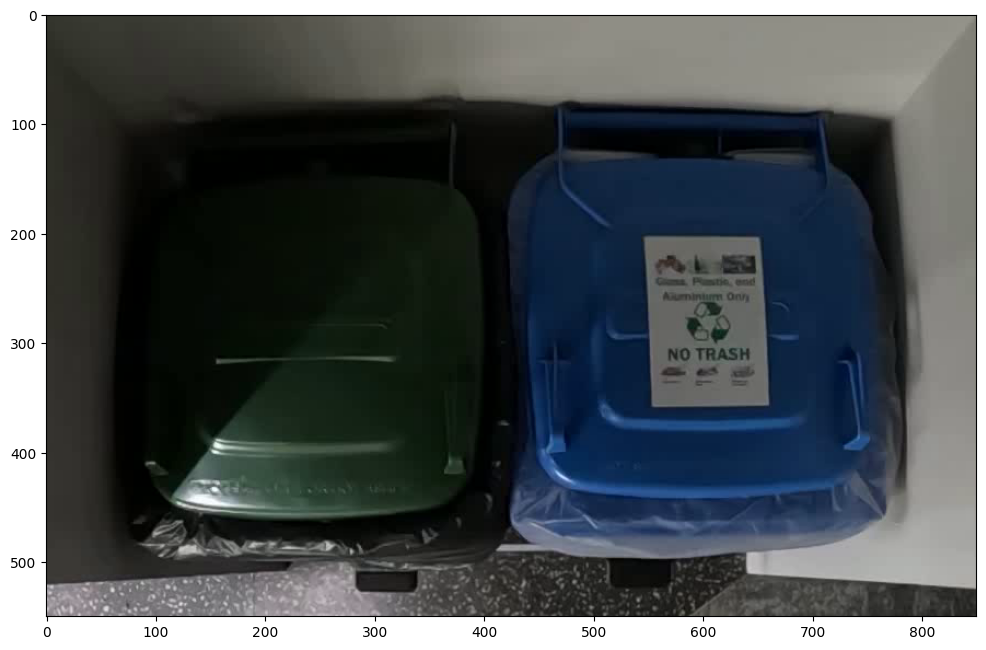

In [30]:
cap = cv2.VideoCapture(cropped_video)

ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)   # convert bgr to rgb for display

plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)

In [42]:
# group consecutive frames into motion events

motion_events = group_consec_frames(frame_indices)

In [43]:
# filter motion event sbased on line crossing

filtered_events = []
for event in motion_events:
    start, end = event[0], event[-1]

    if contains_line_crossing(cropped_video, line_y=510, start=start, end=end):
        filtered_events.append((start, end))

In [44]:
# save only filtered events

clip_id = 1
for event in filtered_events:
    start, end = event[0], event[-1]

    output_path = f"{base_name_cropped}_{clip_id}.mp4"
    save_clip(start, end, cropped_video, output_path)

    print(f"saved {output_path}: frames {start} to {end}")
    clip_id += 1

saved GX030079_cropped_1.mp4: frames 416 to 474
saved GX030079_cropped_2.mp4: frames 5060 to 5134
saved GX030079_cropped_3.mp4: frames 9055 to 9158
saved GX030079_cropped_4.mp4: frames 26845 to 26869
saved GX030079_cropped_5.mp4: frames 30764 to 30832
saved GX030079_cropped_6.mp4: frames 32104 to 32256
saved GX030079_cropped_7.mp4: frames 32404 to 32457
saved GX030079_cropped_8.mp4: frames 32481 to 32484
saved GX030079_cropped_9.mp4: frames 35526 to 35586
saved GX030079_cropped_10.mp4: frames 37091 to 37143
saved GX030079_cropped_11.mp4: frames 37350 to 37497
saved GX030079_cropped_12.mp4: frames 46929 to 47030
saved GX030079_cropped_13.mp4: frames 67091 to 67203
saved GX030079_cropped_14.mp4: frames 67289 to 67342
saved GX030079_cropped_15.mp4: frames 68558 to 68628
saved GX030079_cropped_16.mp4: frames 68652 to 68716
saved GX030079_cropped_17.mp4: frames 68793 to 68822
saved GX030079_cropped_18.mp4: frames 70899 to 70989
saved GX030079_cropped_19.mp4: frames 74847 to 74901
saved GX03

### extract frames from clipped segments

In [12]:
extract_frames("GX030079_clips", "GX030079_frames")

saved 59 frames from GX030079_cropped_1.mp4 to GX030079_frames/GX030079_cropped_1
saved 75 frames from GX030079_cropped_2.mp4 to GX030079_frames/GX030079_cropped_2
saved 104 frames from GX030079_cropped_8.mp4 to GX030079_frames/GX030079_cropped_8
saved 25 frames from GX030079_cropped_17.mp4 to GX030079_frames/GX030079_cropped_17
saved 69 frames from GX030079_cropped_21.mp4 to GX030079_frames/GX030079_cropped_21
saved 153 frames from GX030079_cropped_22.mp4 to GX030079_frames/GX030079_cropped_22
saved 54 frames from GX030079_cropped_23.mp4 to GX030079_frames/GX030079_cropped_23
saved 53 frames from GX030079_cropped_29.mp4 to GX030079_frames/GX030079_cropped_29
saved 148 frames from GX030079_cropped_30.mp4 to GX030079_frames/GX030079_cropped_30
saved 102 frames from GX030079_cropped_32.mp4 to GX030079_frames/GX030079_cropped_32
saved 113 frames from GX030079_cropped_37.mp4 to GX030079_frames/GX030079_cropped_37
saved 54 frames from GX030079_cropped_39.mp4 to GX030079_frames/GX030079_crop